Pick up where I left off...

# Data

Previous modeling effort processed data in notebook `b_/00c`, saved each market's data as a pickle file. Then, when it came time to EDA, modeling -- just read in a .pkl file

Now, the processing code in notebook `00c` is captured by script `preprocess.py`. So we just need to load that data, filter by market, and save a pickle file.

Do this using a script

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import datetime

from sklearn.model_selection import train_test_split

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 100)

## load and inspect

In [3]:
DATA_DIR = "/data/16/kendra.frederick/shopping_grid/output/market_pkl_files_take2/"

In [4]:
!ls $DATA_DIR

ATL-EWR.pkl  EWR-CDG.pkl  EWR-MIA.pkl  JFK-MIA.pkl  LGA-MIA.pkl  OAK-LAS.pkl
ATL-LAS.pkl  EWR-FLL.pkl  JFK-LAX.pkl  LAX-EWR.pkl  LHR-EWR.pkl  SFO-LAX.pkl
AUS-DEN.pkl  EWR-LAX.pkl  JFK-LGW.pkl  LAX-JFK.pkl  LHR-JFK.pkl
DFW-ORD.pkl  EWR-LHR.pkl  JFK-LHR.pkl  LAX-SFO.pkl  LHR-LAX.pkl


In [5]:
market = "LAX-JFK"
filename = "{}.pkl".format(market)
df = pd.read_pickle(os.path.join(DATA_DIR, filename))

In [6]:
len(df)

121315

## helper funcs

In [7]:
def plot_min_fare(market_pdf, dd, rd, market):
    trip_df = market_pdf[(market_pdf['outDeptDt'] == dd) & (market_pdf['inDeptDt'] == rd)]
    trip_df.sort_values(by='searchDt_dt', inplace=True)
    plt.figure(figsize=(12,5))
    plt.plot(-trip_df['days_til_dept'], trip_df['min_fare'], marker='o')
    plt.xlabel("advanced purchase days")
    plt.ylabel('min fare (USD)')
    plt.title(f"{market} - depart {dd} - return {rd}");

# train-test split 

prior to EDA

In [8]:
target_col = 'min_fare'
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=19)
train_pdf = pd.concat([X_train, y_train], axis=1)
train_pdf["train_test"] = "train"
X_test["train_test"] = "test"
mask_df = pd.concat([train_pdf, X_test], axis=0, sort=False)

# RT vs OW

In [9]:
df_rt = mask_df[mask_df['round_trip'] == 1].dropna(subset=[target_col])
df_ow = mask_df[mask_df['round_trip'] == 0].dropna(subset=[target_col])

In [10]:
len(df_rt), len(df_ow)

(100990, 8193)

## RT

In [11]:
data = df_rt['min_fare']

In [12]:
df_rt['min_fare'].describe()

count    100990.000000
mean        425.622876
std         176.711142
min         191.600000
25%         297.600000
50%         383.200000
75%         503.200000
max        4263.210000
Name: min_fare, dtype: float64

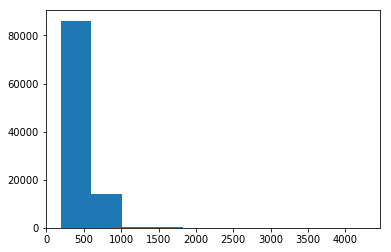

In [13]:
plt.hist(df_rt['min_fare']);

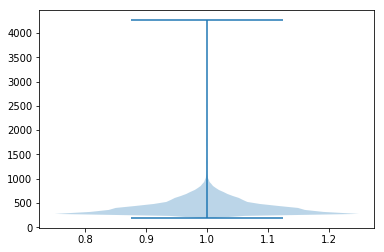

In [14]:
plt.violinplot(df_rt['min_fare']);

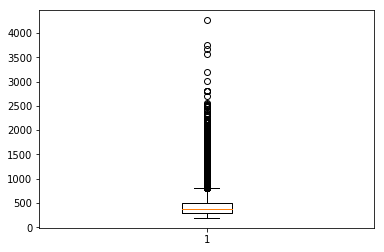

In [15]:
plt.boxplot(df_rt['min_fare']);

In [16]:
# # filter out anomalously high/low fares
# count_llim = data_params['count_llim']
# fare_ulim = np.percentile(data, market_configs["fare_ulim_percentile"])
# fare_llim = np.percentile(market_pdf[target_col], market_configs["fare_llim_percentile"])

for q in [0.1, 1, 5, 50, 95, 99, 99.9]:
    print(f"{q}%: {np.percentile(data, q)}")

0.1%: 197.2
1%: 217.2
5%: 257.21
50%: 383.2
95%: 747.19
99%: 950.2
99.9%: 1795.2


In [17]:
print("Lower q, value, num data less than")
for q in [0.1, 0.25, 0.5]:
    llim = np.percentile(data, q)
    toss_data = data[data <= llim]
    clipped_data = data[data>llim]
    print(f"{q}%, {llim:.0f}, {len(toss_data)}")

Lower q, value, num data less than
0.1%, 197, 349
0.25%, 197, 349
0.5%, 217, 2274


In [18]:
print("Upper q, value, num data greater than")
for q in [99, 99.5, 99.75, 99.9]:
    ulim = np.percentile(data, q)
    toss_data = data[data >= ulim]
    clipped_data = data[data < ulim]
    print(f"{q}%, {ulim:.0f}, {len(toss_data)}")

Upper q, value, num data greater than
99%, 950, 1018
99.5%, 1093, 505
99.75%, 1369, 253
99.9%, 1795, 102


In [19]:
lq = 0.25
uq = 99.75

llim = np.percentile(data, lq)
ulim = np.percentile(data, uq)

clip_rt_df = df_rt[df_rt['min_fare'].between(llim, ulim)]
len(clip_rt_df) / len(df_rt)

0.9974650955540153

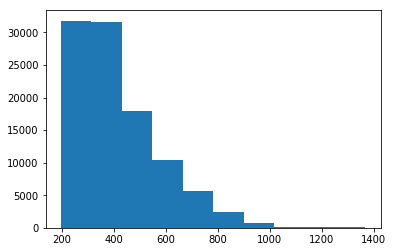

In [20]:
plt.hist(clip_rt_df['min_fare']);

Not a normal distribution, but less skewed than before

ALT: use multiple of median instead of percentiles

## OW

In [21]:
df_ow['min_fare'].describe()

count    8193.000000
mean      161.354948
std        45.640590
min        98.600000
25%       131.600000
50%       143.600000
75%       188.200000
max       412.100000
Name: min_fare, dtype: float64

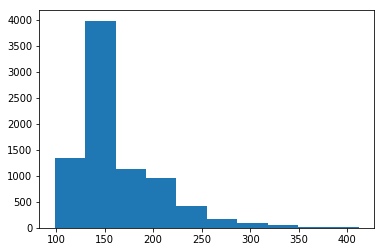

In [22]:
plt.hist(df_ow['min_fare']);

More normally distributed than RT fares

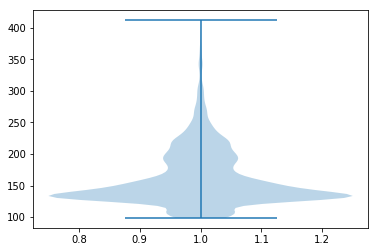

In [23]:
plt.violinplot(df_ow['min_fare']);

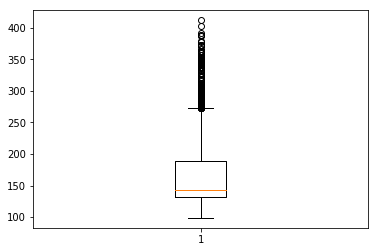

In [24]:
plt.boxplot(df_ow['min_fare']);

In [25]:
data = df_ow['min_fare']

In [26]:
for q in [0.1, 1, 5, 50, 95, 99, 99.9]:
    print(f"{q}%: {np.percentile(data, q)}")

0.1%: 98.6
1%: 98.6
5%: 108.6
50%: 143.6
95%: 248.6
99%: 316.60720000000003
99.9%: 372.6


In [27]:
print("Lower q, value, num data less than")
for q in [0.1, 0.25, 0.5, 1]:
    llim = np.percentile(data, q)
    toss_data = data[data <= llim]
    clipped_data = data[data>llim]
    print(f"{q}%, {llim:.0f}, {len(toss_data)}")

Lower q, value, num data less than
0.1%, 99, 269
0.25%, 99, 269
0.5%, 99, 269
1%, 99, 269


In [28]:
print("Upper q, value, num data greater than")
for q in [99, 99.5, 99.75, 99.9, 99.99]:
    ulim = np.percentile(data, q)
    toss_data = data[data >= ulim]
    clipped_data = data[data < ulim]
    print(f"{q}%, {ulim:.0f}, {len(toss_data)}")

Upper q, value, num data greater than
99%, 317, 82
99.5%, 344, 45
99.75%, 361, 21
99.9%, 373, 10
99.99%, 404, 1


In [29]:
data = df_ow['min_fare']
lq = 0
uq = 100

llim = np.percentile(data, lq)
ulim = np.percentile(data, uq)

clip_ow_df = df_ow[df_ow['min_fare'].between(llim, ulim)]
len(clip_ow_df) / len(df_ow)

1.0

# EDA
focusing on OW. Less data, but more "well-behaved"

## by dtd

In [30]:
dtd_grp = clip_ow_df.groupby('days_til_dept').agg(
    {'min_fare': ['mean', 'std', np.median]}
)

dtd_grp.columns = ['avg_min_fare', 'std_min_fare', 'median_min_fare']
dtd_grp.reset_index(inplace=True)

dtd_grp.sort_values(by='days_til_dept', inplace=True)

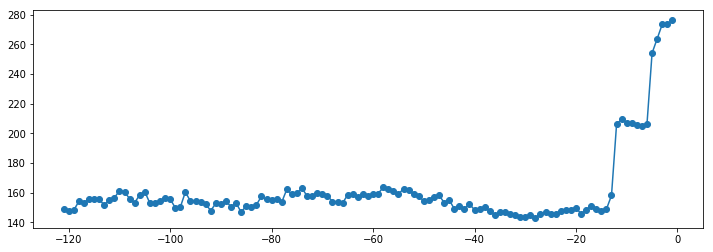

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(-dtd_grp['days_til_dept'], dtd_grp['avg_min_fare'], marker='o');

In [80]:
dtd_grp.head(21)

,days_til_dept,avg_min_fare,std_min_fare,median_min_fare
0,1,124.342167,38.688550,117.59
1,2,110.581884,28.855584,102.59
2,3,107.057917,25.748423,102.59
3,4,90.266765,10.600504,91.59
4,5,86.899706,12.423400,91.59
5,6,63.248429,13.237865,72.59
6,7,60.683846,12.214955,63.60
7,8,62.278358,11.954417,68.60
8,9,62.935075,11.563306,72.59
9,10,62.061364,11.606680,68.60


In [32]:
# conservative? (x=13) or permissive? (x=6)
dtd_cutoff = 6
clip_ow_df['dtd_regime'] = np.where(clip_ow_df['days_til_dept'] < dtd_cutoff, 'close_to_dept', 'farther_out')
far_out_df = clip_ow_df[clip_ow_df['dtd_regime'] == 'farther_out']

## by DOW

In [33]:
dow_list =  ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_dict = dict(zip(range(7), dow_list))

def extract_dow(df, ow=False):
    df['dept_dt_dow_int'] = df['outDeptDt_dt'].apply(
            lambda d: datetime.date.weekday(d))
    df['dept_dt_dow'] = df['dept_dt_dow_int'].map(
        dow_dict)
    if not ow:
        df['return_dt_dow'] = df['inDeptDt_dt'].apply(
                lambda d: datetime.date.weekday(d))
    return df

# def extract_dow_type(df, dow_int_col):
#     new_col = dow_int_col.replace('_int', '_type')
#     print(new_col)
#     df[new_col] = np.where(df[dow_int_col].isin([4,5]), 'weekend', 
#                            np.where(df[dow_int_col].isin([3,6]), 'shoulder', 'weekday')
#                           )
#     return df

In [34]:
far_out_df = extract_dow(far_out_df, ow=True)

In [35]:
# dow_summ = mask_df.groupby(["dept_dt_dow"])["min_fare"].mean()
dow_summ = far_out_df.groupby(["dept_dt_dow"]).agg(
    {"min_fare": ['mean', 'std', np.median]}
)
dow_summ = pd.DataFrame(dow_summ)

dow_summ.columns = ['avg_min_fare', 'std_min_fare', 'median_min_fare']

dow_summ.reset_index(inplace=True)

dow_summ['dow_int'] = dow_summ['dept_dt_dow'].apply(lambda x: dow_list.index(x))

dow_summ.sort_values(by='dow_int', inplace=True)

In [36]:
dow_summ

,dept_dt_dow,avg_min_fare,std_min_fare,median_min_fare,dow_int
1,Mon,159.235957,38.576083,141.6,0
5,Tue,151.169697,38.678639,131.6,1
6,Wed,148.912048,35.739902,140.6,2
4,Thu,154.192330,34.186152,147.4,3
0,Fri,155.353034,41.416311,140.6,4
2,Sat,159.290559,45.259844,141.6,5
3,Sun,168.663067,39.722800,158.6,6


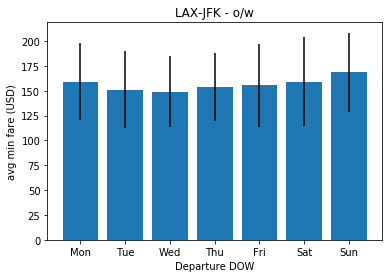

In [37]:
xs = range(7)
plt.bar(xs, dow_summ['avg_min_fare'], yerr=dow_summ['std_min_fare'])
plt.xticks(xs, dow_list);
plt.ylabel("avg min fare (USD)")
plt.xlabel("Departure DOW")
plt.title(f"{market} - o/w");

Pretty consistent across DOW

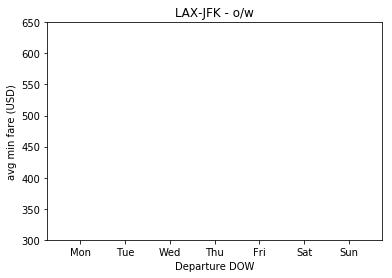

In [38]:
xs = range(7)
plt.bar(xs, dow_summ['avg_min_fare'], yerr=dow_summ['std_min_fare'])
plt.xticks(xs, dow_list);
plt.ylabel("avg min fare (USD)")
plt.xlabel("Departure DOW")
plt.ylim(300, 650)
plt.title(f"{market} - o/w");

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


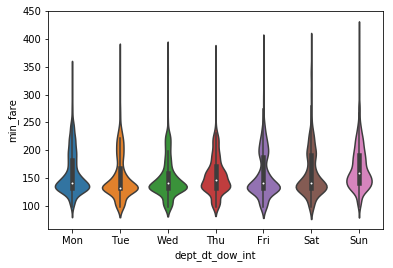

In [39]:
sns.violinplot(data=far_out_df, x='dept_dt_dow_int', y='min_fare');
plt.xticks(range(7), dow_list);

# EDA on +/- 1 dept day

Actually, let's just look back for "prev dept day", regardless of "dow type", and use that info to inform how we define "dow type"

In [40]:
eda_shifted_features_dict = {
    # shift search day -1
    "min_fare_prev_search_day": {
        'sort_col': 'searchDt',
        'groupby_cols': ['outDeptDt', 'inDeptDt']
    },
    # shift departure day +/- 1
    "min_fare_prev_dept_day": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "min_fare_next_dept_day": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in eda_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])[target_col]
                    .shift(kwargs.get("shift", 1)) 
                )

dow_shifted_features_dict = {
    # shift departure day +/- 1
    "prev_dept_dow": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "next_dept_dow": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in dow_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])['dept_dt_dow']
                    .shift(kwargs.get("shift", 1)) 
                )


dow_shifted_features_dict = {
    # shift departure day +/- 1
    "prev_dept_dow_int": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt']
    },
    "next_dept_dow_int": {
        'sort_col': 'outDeptDt',
        'groupby_cols': ['searchDt'],
        'shift': -1
    },
}

for feature_name, kwargs in dow_shifted_features_dict.items():
    far_out_df[feature_name] = (far_out_df
                    .sort_values(by=kwargs['sort_col'])
                    .groupby(kwargs['groupby_cols'])['dept_dt_dow_int']
                    .shift(kwargs.get("shift", 1)) 
                )

In [41]:
far_out_df.head()

,market,origin,destination,round_trip,pos,currency,outDeptDt,inDeptDt,shop_counts,origin_country,origin_city,destination_country,destination_city,outDeptDt_dt,inDeptDt_dt,searchDt_dt,days_til_dept,stay_duration,shop_ind,searchDt,min_fare,train_test,dtd_regime,dept_dt_dow_int,dept_dt_dow,min_fare_prev_search_day,min_fare_prev_dept_day,min_fare_next_dept_day,prev_dept_dow,next_dept_dow,prev_dept_dow_int,next_dept_dow_int
855068,LAX-JFK,LAX,JFK,0,US,USD,20221218,0,350,US,LAX,US,NYC,2022-12-18,None,2022-10-09,70,NaN,1,20221009,175.10,train,farther_out,6,Sun,191.60,201.61,145.1,Sat,Tue,5.0,1.0
666364,LAX-JFK,LAX,JFK,0,US,USD,20221121,0,1207,US,LAX,US,NYC,2022-11-21,None,2022-11-12,9,NaN,1,20221112,226.60,train,farther_out,0,Mon,226.60,226.60,236.6,Sun,Tue,6.0,1.0
393634,LAX-JFK,LAX,JFK,0,US,USD,20221205,0,320,US,LAX,US,NYC,2022-12-05,None,2022-10-22,44,NaN,1,20221022,151.60,train,farther_out,0,Mon,151.60,151.60,151.6,Sun,Tue,6.0,1.0
1345488,LAX-JFK,LAX,JFK,0,US,USD,20221231,0,252,US,LAX,US,NYC,2022-12-31,None,2022-09-21,101,NaN,1,20220921,338.59,train,farther_out,5,Sat,338.59,218.59,131.6,Fri,Sun,4.0,6.0
477708,LAX-JFK,LAX,JFK,0,US,USD,20230213,0,87,US,LAX,US,NYC,2023-02-13,None,2022-10-15,121,NaN,1,20221015,98.60,train,farther_out,0,Mon,NaN,98.60,NaN,Sun,NaN,6.0,NaN


In [42]:
ex_df = far_out_df[far_out_df['searchDt'] == 20221101]
ex_df.sort_values(by='outDeptDt_dt', inplace=True)
ex_df[['outDeptDt_dt', 'dept_dt_dow', 'min_fare', 
       'prev_dept_dow', 'min_fare_prev_dept_day', ]].head(15)

,outDeptDt_dt,dept_dt_dow,min_fare,prev_dept_dow,min_fare_prev_dept_day
1095628,2022-11-07,Mon,222.72,NaN,NaN
1095276,2022-11-08,Tue,206.30,Mon,222.72
1097174,2022-11-09,Wed,222.72,Tue,206.30
1096003,2022-11-10,Thu,222.89,Wed,222.72
1095642,2022-11-11,Fri,231.60,Thu,222.89
1099803,2022-11-12,Sat,223.58,Fri,231.60
1095343,2022-11-13,Sun,225.08,Sat,223.58
1095792,2022-11-14,Mon,151.60,Sun,225.08
1095685,2022-11-15,Tue,148.91,Mon,151.60
1097317,2022-11-16,Wed,160.60,Tue,148.91


In [43]:
comp_col = 'min_fare_prev_search_day'
df_no_null = far_out_df.dropna(subset=['min_fare', comp_col])
np.corrcoef(df_no_null['min_fare'], df_no_null[comp_col])

array([[1.        , 0.78105871],
       [0.78105871, 1.        ]])

Still correlates really well

In [44]:
comp_col = 'min_fare_prev_dept_day'
df_no_null = far_out_df.dropna(subset=['min_fare', comp_col])
np.corrcoef(df_no_null['min_fare'], df_no_null[comp_col])

array([[1.        , 0.68307435],
       [0.68307435, 1.        ]])

This is pretty good as well

In [45]:
far_out_df['fare_diff_prev_shop_dt'] = far_out_df['min_fare'] - far_out_df['min_fare_prev_search_day']
far_out_df['fare_diff_prev_dept_dt'] = far_out_df['min_fare'] - far_out_df['min_fare_prev_dept_day']

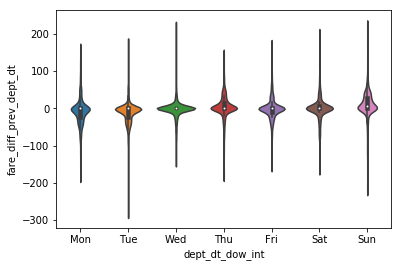

In [46]:
sns.violinplot(data=far_out_df, x='dept_dt_dow_int', y='fare_diff_prev_dept_dt');
plt.xticks(range(7), dow_list);

Not much difference day-to-day

In [47]:
# not_close_df = mask_df[np.abs(mask_df['fare_diff_prev_dept_dt']) > 50]
# close_df = mask_df[np.abs(mask_df['fare_diff_prev_dept_dt']) <20]

# len(not_close_df), len(close_df)

## plots of individual trips

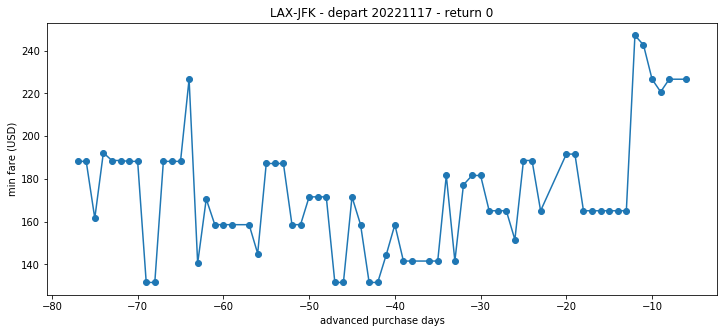

In [48]:
plot_min_fare(far_out_df, 20221117, 0, market)

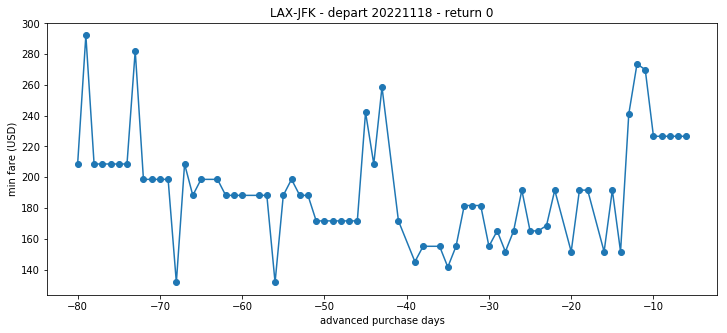

In [49]:
plot_min_fare(far_out_df, 20221118, 0, market)

Yikes

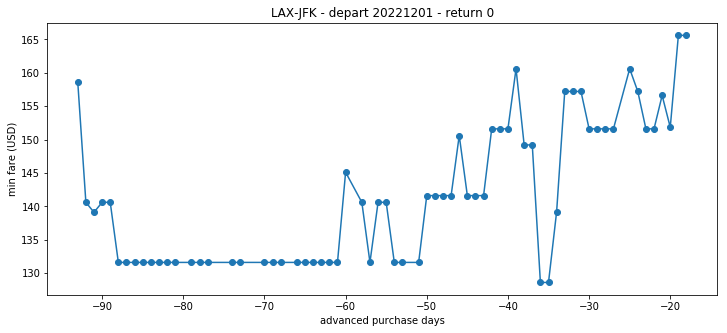

In [50]:
plot_min_fare(far_out_df, 20221201, 0, market)

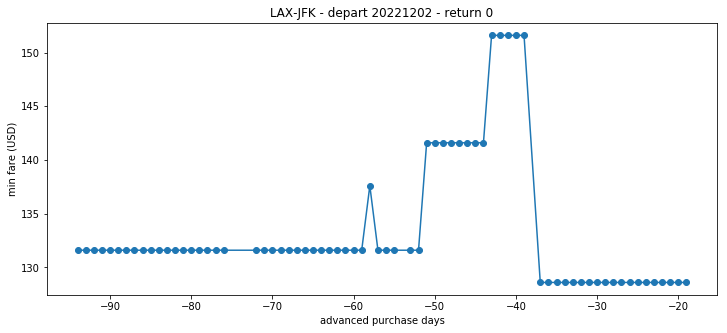

In [51]:
plot_min_fare(far_out_df, 20221202, 0, market)

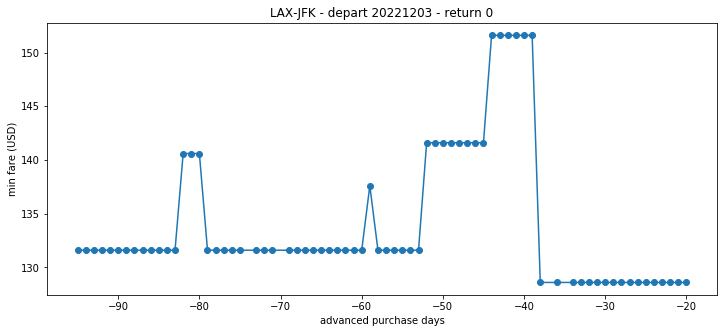

In [52]:
plot_min_fare(far_out_df, 20221203, 0, market)

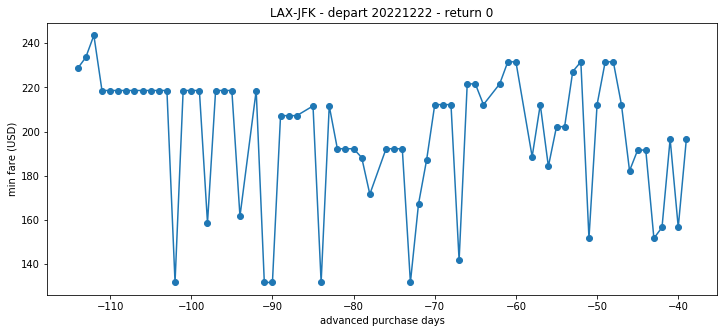

In [53]:
plot_min_fare(far_out_df, 20221222, 0, market)

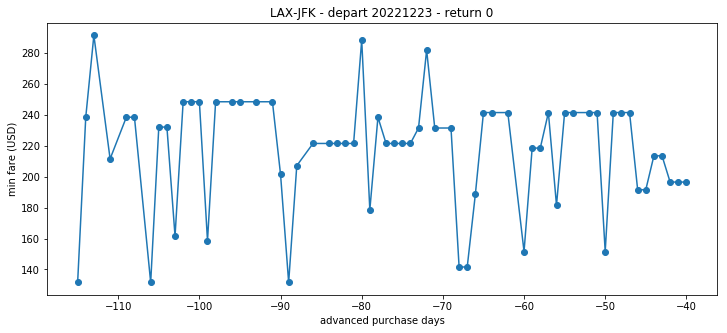

In [54]:
plot_min_fare(far_out_df, 20221223, 0, market)

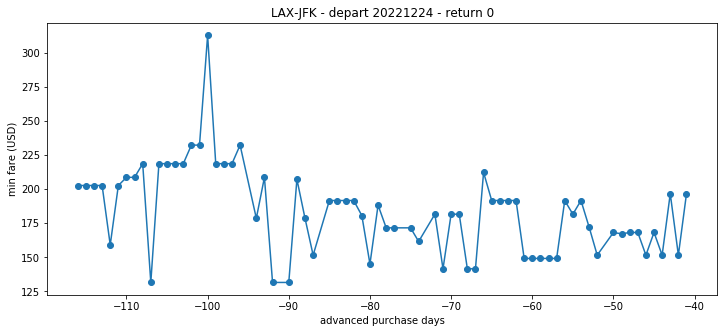

In [55]:
plot_min_fare(far_out_df, 20221224, 0, market)

Volatility for the holidays

## heatmaps

### fares

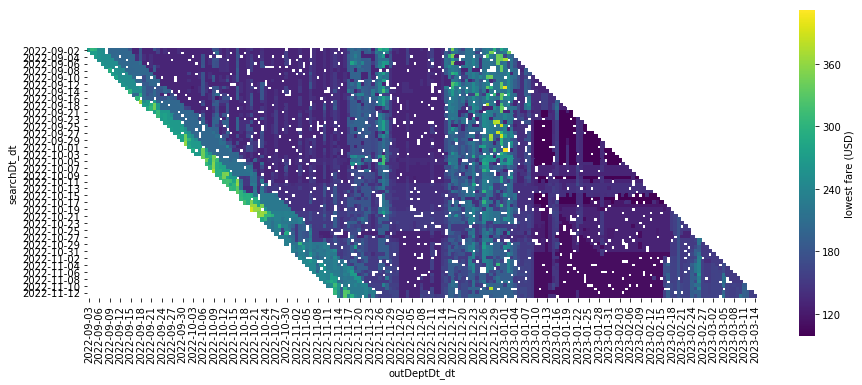

In [56]:
# data *not* filtered by dtd regime
clip_for_plot = clip_ow_df[(clip_ow_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(clip_ow_df['searchDt_dt'] > datetime.date(2022,9,1))]

plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="min_fare")
sns.heatmap(pvt_data, cmap='viridis', square=True,
                cbar_kws={'label': 'lowest fare (USD)',
                            'shrink': 0.5,
                            }
                );

### vs. previous shop day

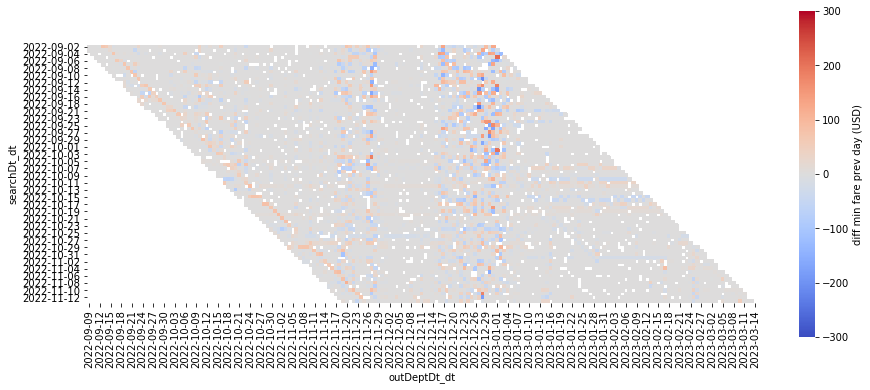

In [57]:
# don't include close-to-departure-date data
clip_for_plot = far_out_df[(far_out_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(far_out_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_shop_dt")
sns.heatmap(pvt_data, cmap='coolwarm', square=True,
                cbar_kws={'label': 'diff min fare prev day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300
                );

Holiday fares appear to be less volatile

Boolean: are fares close or not?

In [58]:
far_out_df['fare_prev_shop_dt_close'] = np.where(
    np.isclose(far_out_df['min_fare'], far_out_df['min_fare_prev_search_day'], 0.01), 1, 0)

comp_df = far_out_df.dropna(subset=['min_fare', 'min_fare_prev_search_day'])

In [59]:
comp_df['fare_prev_shop_dt_close'].value_counts(1)

1    0.6234
0    0.3766
Name: fare_prev_shop_dt_close, dtype: float64

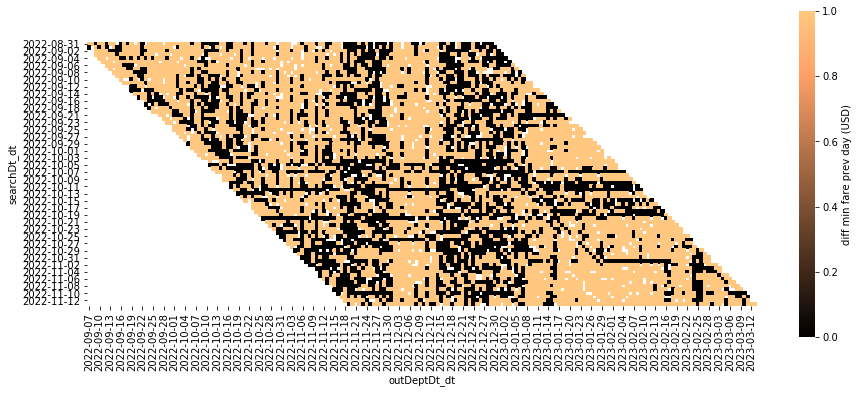

In [60]:
# clip_for_plot = mask_df[(mask_df['outDeptDt_dt'] > datetime.date(2022,9,1))
#                        &(mask_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = comp_df.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_prev_shop_dt_close")

sns.heatmap(pvt_data, cmap='copper', square=True,
                cbar_kws={'label': 'diff min fare prev day (USD)',
                            'shrink': 0.5,
                            }
                );

Across the board, prev search day's fare is not accurate enough

### vs prev dept day

In [61]:
# computed above:
# mask_df['fare_diff_prev_dept_dt'] = mask_df['min_fare'] - mask_df['min_fare_prev_dept_day']

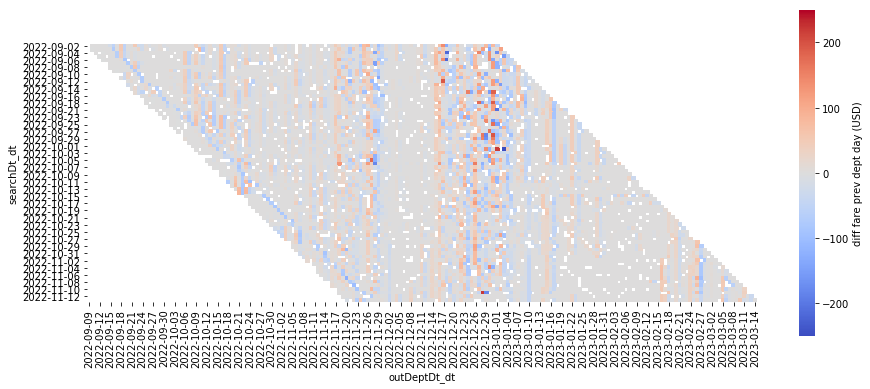

In [62]:
clip_for_plot = far_out_df[(far_out_df['outDeptDt_dt'] > datetime.date(2022,9,1))
                       &(far_out_df['searchDt_dt'] > datetime.date(2022,9,1))]
plt.figure(figsize=(15,12))
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
sns.heatmap(pvt_data, cmap='coolwarm', square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-250, vmax=250
                );

#### Examine by DOW

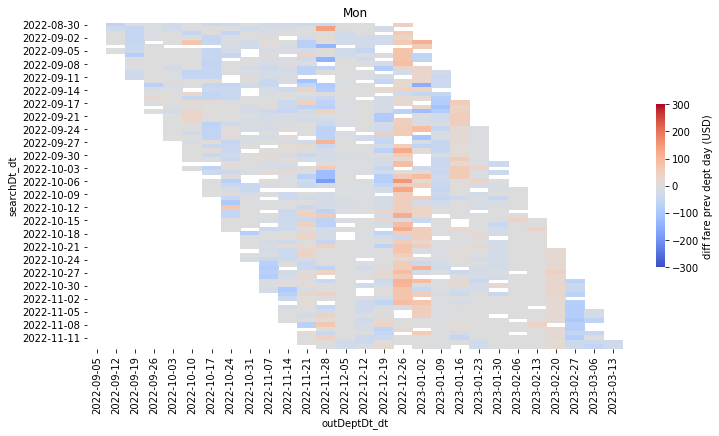

In [63]:
dow = "Mon"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

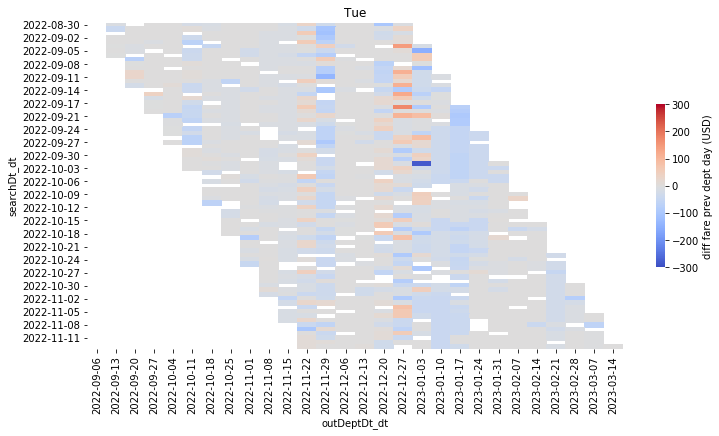

In [64]:
dow = "Tue"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

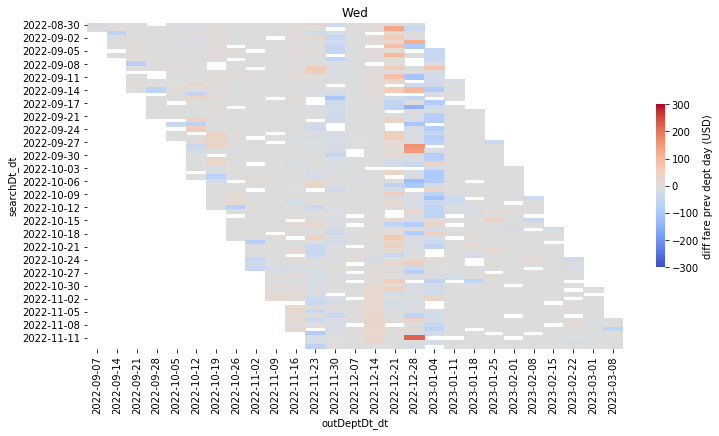

In [65]:
dow = "Wed"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

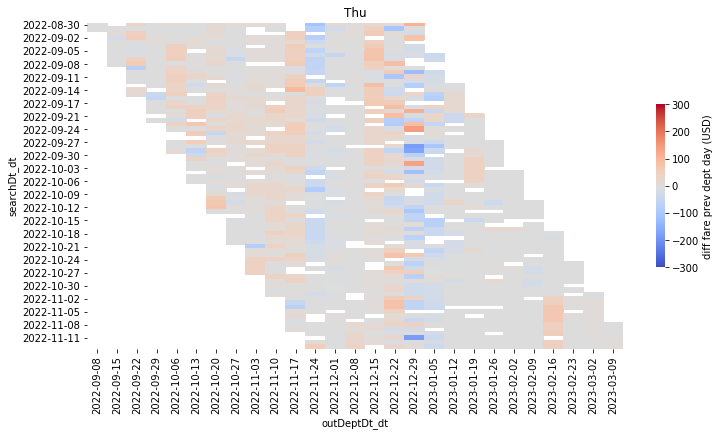

In [66]:
dow = "Thu"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

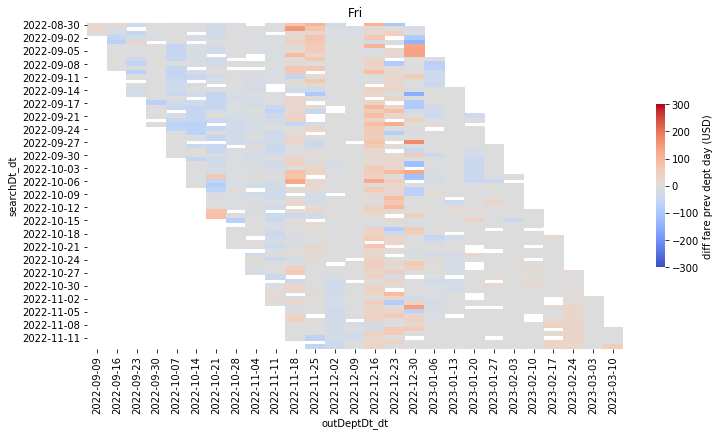

In [67]:
dow = "Fri"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

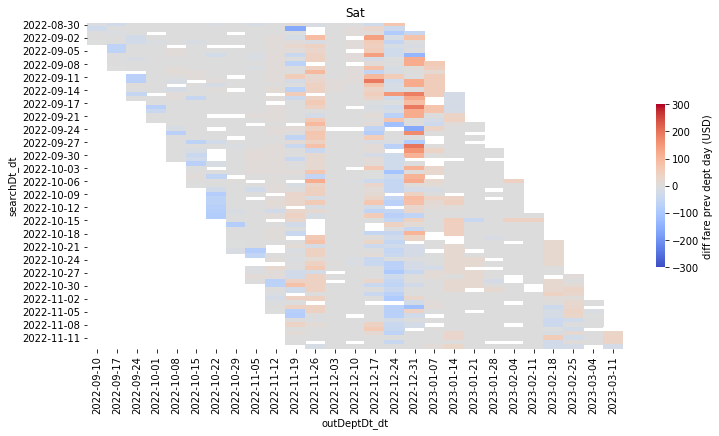

In [68]:
dow = "Sat"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

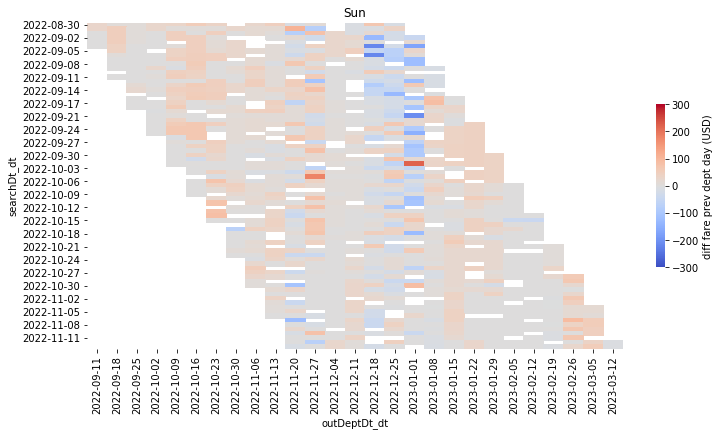

In [69]:
dow = "Sun"
clip_for_plot = far_out_df[(far_out_df['dept_dt_dow'] == dow)]
pvt_data = clip_for_plot.pivot(index="searchDt_dt", columns="outDeptDt_dt", values="fare_diff_prev_dept_dt")
plt.figure(figsize=(12,6))
sns.heatmap(pvt_data, cmap='coolwarm', #square=True,
                cbar_kws={'label': 'diff fare prev dept day (USD)',
                            'shrink': 0.5,},
            vmin=-300, vmax=300);
plt.title(dow);

### conclusion (?)

For some DOW's, the difference between prev dept day appears to be consistent across a departure day
- so: feature(s) we should engineer & pull forward is/are: 
    - prev fare diff + prev day fare
    - median prev fare diff (last 3 days) + median prev day fare (last 3 days)

In [70]:
far_out_df['shifted_fare_diff_prev_dd'] = (far_out_df
                                        .sort_values(by=['searchDt'])
                                        .groupby(['outDeptDt'])['fare_diff_prev_dept_dt']
                                        .shift(1)
                                       )
far_out_df['calc_fare_from_prev_dd'] = far_out_df['min_fare_prev_dept_day'] + far_out_df['shifted_fare_diff_prev_dd']

In [71]:
# ex_df = far_out_df[far_out_df['outDeptDt'] == 20221105]
# ex_df.sort_values(by='searchDt_dt', inplace=True)
# ex_df[['searchDt_dt', 'dept_dt_dow', 'dtd_regime', 'min_fare', 'min_fare_prev_dept_day', 'fare_diff_prev_dept_dt', 
#        'shifted_fare_diff_prev_dd', 'calc_fare_from_prev_dd']].head(15)

In [72]:
comp_df = far_out_df.dropna(subset=['min_fare', 'calc_fare_from_prev_dd'])
np.corrcoef(comp_df['min_fare'], comp_df['calc_fare_from_prev_dd'])

array([[1.        , 0.67643219],
       [0.67643219, 1.        ]])

I wonder how much Holiday volatility is contributing to this

In [73]:
holiday_start = datetime.date(2022,12,16)
holiday_end = datetime.date(2023,1,3)
not_holiday_df = far_out_df[
    (far_out_df['outDeptDt_dt'] < holiday_start) | (far_out_df['outDeptDt_dt'] > holiday_end)
]

Technically, should go back & recalculate features, but for now...

In [74]:
comp_df = not_holiday_df.dropna(subset=['min_fare', 'calc_fare_from_prev_dd'])
print(len(comp_df))
np.corrcoef(comp_df['min_fare'], comp_df['calc_fare_from_prev_dd'])

6331


array([[1.        , 0.73402462],
       [0.73402462, 1.        ]])